In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd

In [16]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [17]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [18]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [19]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                time.append(float(split[0]))
                momentrate.append(float(split[1]))
    print(momentrate[0:5])
    momentrate = np.array(momentrate)
    time = np.array(time)

    return momentrate, time

In [20]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [[]]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append([])
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(float(split[1]))
            else:
                stf_count += 1
    return momentrate, time

In [21]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [22]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [23]:
def plot_stf(ax, time, momentrate, detected_end_time, linecolor = 'k', linestyle = '--', label_str = '', plot_bar = True):
    ax.plot(time, momentrate, color=linecolor, label = label_str + ' STF' )
    if plot_bar is True:
        ax.axhline(max(momentrate)/10, color='#ffa600')
        ax.fill_between(time, 0, 10*max(momentrate)/100, facecolor='#ffa600', alpha=0.1)

    ax.fill_between(time, momentrate, 0, where=momentrate>0, facecolor=linecolor, alpha=0.05)

    ax.axvline(detected_end_time, color=linecolor, linestyle=linestyle, label = label_str + ' end')
    ax.set_ylabel('Moment rate (Nm/s)')
    ax.set_xlabel('Time (s)')

    ax.set_ylim(0, 1.1*max(momentrate))
    ax.set_xlim(0, max(time))

    ax.legend()

    return ax


In [24]:
def find_end_stf(momentrate, time):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[0:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[0:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [25]:
colors = ['#003f5c', '#bc5090', '#ef5675', 'g', 'c', 'm', 'k', 'y']
styles = ['--', '-.', ':', '--', '-.', ':', '--', '-.']

already_made = os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/figures/ends/panels/moy/')

scardec_durations = []
ye_durations = []
usgs_durations = []
sigloch_durations = []

magnitudes = []
for i, row in combined.iterrows():
    magnitudes.append(row.mag)
    # if row.event + '.png' in already_made:
    #     continue
    count = 0
    print(row)
    sources = 0
    for r in row[1:-1]:
        if r not in [0, '0']:
            sources += 1

    max_end = 0

    if row.scardec not in ['0', 0]:
        momentrate, time = get_scardec_stf(row['scardec'], wanted_type='fctmoy')
        detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time
        max_end = max(max_end, max(time))
        scardec_durations.append(detected_end_time)
        count += 1
    else:
        scardec_durations.append(None)
    if row.ye not in ['0', 0]:
        momentrate, time = get_ye_stf(row['ye'])
        detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time
        max_end = max(max_end, max(time))
        count += 1
        ye_durations.append(detected_end_time)
    else:
        ye_durations.append(None)
    if row.usgs not in ['0', 0]:
        momentrate, time = get_usgs_stf(row['usgs'])
        detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time
        max_end = max(max_end, max(time))
        count += 1
        usgs_durations.append(detected_end_time)
    else:
        usgs_durations.append(None)
    if row.sigloch not in ['0', 0]:
        momentrate_list, time_list = get_sigloch_stf(row['sigloch'])
        y_max = 0
        lines_count = count
        durations = []
        for momentrate, time in zip(momentrate_list, time_list):
            momentrate = np.array(momentrate)
            y_max = max(y_max, max(momentrate))
            time = np.arange(0, 25.6, 0.1)#np.array(time)
            detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(10**momentrate, time)
            time = time - detected_start_time # shift to start STF at zero
            detected_end_time = detected_end_time - detected_start_time
            durations.append(detected_end_time)
            max_end = max(detected_end_time, max_end)
            lines_count += 1
        count += 1
        sigloch_durations.append(durations)
    else:
        sigloch_durations.append(None)

    # if i > 100:
    #     break

# plt.show()









event                                       20170818_0259
scardec    FCTs_20170818_025925_NORTH_OF_ASCENSION_ISLAND
ye                                                      0
isc                                                     0
sigloch                                                 0
usgs                                                    0
mag                                                 6.591
Name: 0, dtype: object
event                                         20110126_1542
scardec    FCTs_20110126_154229_NORTHERN_SUMATRA__INDONESIA
ye                                                        0
isc                                                       0
sigloch                                     0706.2011.026.a
usgs                                                      0
mag                                                   6.114
Name: 1, dtype: object
event                                          19981010_1629
scardec    FCTs_19981010_162908_MINAHASSA_PENINSULA__SULA...
ye    

In [26]:
len(scardec_durations)

5615

In [27]:
all_sigloch_durations = []
all_magnitudes = []

for mag, durations in zip(magnitudes, sigloch_durations):
    if durations is not None:
        #for duration in durations:
        all_sigloch_durations.append(max(durations))
        all_magnitudes.append(mag)


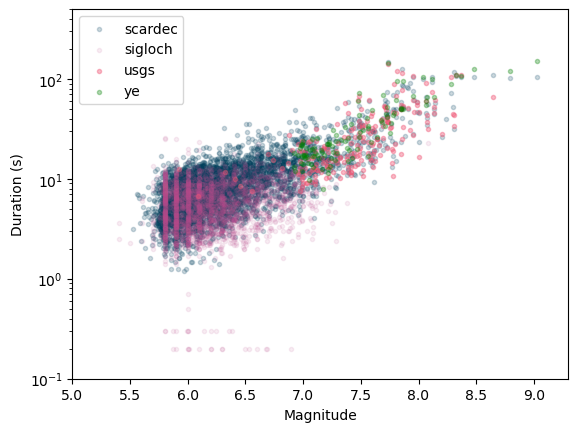

In [28]:
plt.scatter(magnitudes, scardec_durations, label='scardec', color = colors[0], alpha=0.2, marker='.')

plt.scatter(all_magnitudes, all_sigloch_durations, color = colors[1], label='sigloch', alpha=0.1, marker='.')

plt.scatter(magnitudes, usgs_durations, label='usgs', color = colors[2], alpha=0.4, marker='.')
plt.scatter(magnitudes, ye_durations, label='ye', color = colors[3], alpha=0.3, marker='.')


plt.legend()
plt.yscale('log')
plt.xlim([5, 9.3])
plt.ylim([0.1, 500])

plt.ylabel('Duration (s)')
plt.xlabel('Magnitude')

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/ends/durations_longest_sigloch.png')